# In this notebook we will be trying the transformer architecture
This choice is motivated by the fact that the transformer excels at seqtoseq, and is able to capture dependencies spatially and temporally. I hypothesize that this is a good fit for the task since ECOG data is very complex and has dependencies in both time and space.

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
import math
from torch.cuda.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
import matplotlib.pyplot as plt

In [28]:
# hyper hyper parameters
# run optuna?
train = False
run_optuna = True

## Data Processing

In [3]:
def calculate_vectors(coords, resolution):
    """
    Calculate the average vectors of x and y magnitudes given a resolution.

    Parameters:
    coords (list of tuples): An array of (x, y) coordinates.
    resolution (int): The resolution number.

    Returns:
    list of tuples: An array of vectors of x and y magnitudes.
    """
    if resolution <= 0:
        raise ValueError("Resolution must be a positive integer.")
    
    n = len(coords)
    if resolution > n:
        raise ValueError("Resolution cannot be greater than the length of the coordinates array.")
    
    # Calculate the segment length
    segment_length = n // resolution
    
    vectors = []
    
    for i in range(0, n, segment_length):
        segment = coords[i:i + segment_length]
        if len(segment) < segment_length:
            break
        
        # Calculate the average change in x and y
        delta_x = np.mean([segment[j+1][0] - segment[j][0] for j in range(len(segment) - 1)])
        delta_y = np.mean([segment[j+1][1] - segment[j][1] for j in range(len(segment) - 1)])
        
        vectors.append((delta_x, delta_y))
    
    return vectors

In [4]:
def vectorize_joystick_readings(x, y, resolution):
     return calculate_vectors(list(zip(x, y)), resolution)

    

In [5]:
def ica(X, n_components):
    ica = FastICA(n_components=n_components)
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    return S_, A_

In [6]:
def normalize_data(d1):
    scaler = MinMaxScaler()
    d1 = scaler.fit_transform(d1)
    return d1

def standardize_data(d1):
    scaler = StandardScaler()
    d1 = scaler.fit_transform(d1)
    return d1

def train_test_split(X, y, train_size):
    train_size = int(train_size * len(X))
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:]

def chunk_data(data, length):
    chunk_size = length
    return [data[i:i+chunk_size] for i in range(0, len(data), len(data)//chunk_size) if i+chunk_size <= len(data)]

        

In [7]:
def load_process_joystick_data(patient_idx):
    # Load data from file
    fname = './data/joystick_track.npz'
    alldat = np.load(fname, allow_pickle=True)['dat']
    dat = alldat[0]
    d = dat[patient_idx]
    scale_up = 10
    # Extract ECoG data and joystick vectors
    ecog_data = d['V']
    targetX = d['targetX']
    targetY = d['targetY']
    
    print(ecog_data.shape, targetX.shape, targetY.shape )
    # Normalize and PCA
    ecog_data = PCA(n_components=0.95).fit_transform(ecog_data)
    print(ecog_data.shape, targetX.shape, targetY.shape )
    # Set resolution and vectorize joystick readings
    resolution = 800
    vectors = np.array(vectorize_joystick_readings(targetX, targetY, resolution))
    vectors = standardize_data(vectors)
    print(ecog_data.shape, vectors.shape)
    # Chunk ECoG data based on resolution
    chunked_ecog_data = chunk_data(ecog_data, len(vectors))
    # Remove data points with zero vectors
    ecog_data, vectors = zip(*[(x, y) for x, y in zip(ecog_data, vectors) if not np.array_equal(y, [0, 0])])
    print(len(ecog_data), len(ecog_data[0]), len(vectors))
    print(len(chunked_ecog_data), len(chunked_ecog_data[0]), len(chunked_ecog_data[0][0]))
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(chunked_ecog_data, vectors, train_size=0.85)
    
    # Convert data back to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    return X_train, X_test, y_train, y_test


In [8]:
patient_idx = 1
X_train, X_test, y_train, y_test = load_process_joystick_data(patient_idx)
min_len = min(len(X_test), len(y_test))
X_test = X_test[:min_len]
y_test = y_test[:min_len]
# reshape input to be [time steps, batch size, features]

print(X_train.shape, y_train.shape)

(248640, 64) (248640, 1) (248640, 1)
(248640, 28) (248640, 1) (248640, 1)
(248640, 28) (802, 2)
802 28 802
800 802 28
(680, 802, 28) (680, 2)


## 


## Data Augmentation

## Transfromers: robots in disguise

### Swin Transformer

In [9]:
print(torch.cuda.is_available())
torch.set_default_device('cuda') if torch.cuda.is_available() else torch.set_default_device('cpu')


True


In [10]:
# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
X_test = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [11]:
#print all shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train, y_train)

torch.Size([680, 802, 28]) torch.Size([120, 802, 28]) torch.Size([680, 2]) torch.Size([120, 2])
tensor([[[-3.5636e+00, -2.2142e-01,  3.5455e-01,  ..., -4.0250e-01,
           3.7540e-01, -4.1878e-01],
         [-4.2145e+00, -2.3734e-01,  3.7031e-01,  ..., -2.9681e-01,
           3.7048e-01, -3.8401e-01],
         [-4.5517e+00, -2.5918e-01,  3.8189e-01,  ..., -1.7190e-01,
           3.6903e-01, -3.3763e-01],
         ...,
         [-9.1077e+00, -8.2472e-01,  1.9255e+00,  ...,  9.3772e-01,
           1.5713e-01,  3.5137e-01],
         [-8.6032e+00, -8.0648e-01,  1.9614e+00,  ...,  8.9451e-01,
           1.6331e-01,  4.0367e-01],
         [-8.7740e+00, -8.1533e-01,  2.0066e+00,  ...,  8.2623e-01,
           1.5693e-01,  4.4119e-01]],

        [[-2.8339e+00, -1.3258e+00,  1.9912e+00,  ..., -4.5152e-02,
           1.5375e-01,  1.1417e-01],
         [-2.8560e+00, -1.3433e+00,  1.9242e+00,  ..., -1.1944e-02,
           1.3430e-01,  1.1008e-01],
         [-3.0293e+00, -1.3709e+00,  1.8581e+00,

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=6000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]
    
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=6000):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        batch_size, seq_len = x.size()[:2]
        positions = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)
        return x + self.pos_embedding(positions)


class ECoGTransformerEncoder(nn.Module):
    def __init__(self, input_dim, resolution, model_dim, num_heads, num_layers, output_dim, dropout_rate=0.1):
        super(ECoGTransformerEncoder, self).__init__()
        # self.swin_transformer = swin_transformer_v2_t(
        #     in_channels=input_dim,
        #     window_size=8,
        #     input_resolution=(resolution[0], resolution[1]),  # Adjust the input resolution based on your data
        #     sequential_self_attention=True,
        #     use_checkpoint=True
        # )
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = LearnedPositionalEncoding(model_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(model_dim, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #x = self.swin_transformer(x)
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)
        x = checkpoint(self.transformer_encoder, x)
        x = x.permute(1, 0, 2)
        x = self.fc(x[:, -1, :])
        return x



In [13]:
# new loss
class ScaledMSELoss(nn.Module):
    def __init__(self, scale_factor):
        super(ScaledMSELoss, self).__init__()
        self.scale_factor = scale_factor
        self.mse_loss = nn.MSELoss()

    def forward(self, input, target):
        return self.mse_loss(input, target) * self.scale_factor

# Example usage
scale_factor = 1000  # Adjust the scale factor as needed

In [14]:
# hyperparameters
input_dim = X_train.shape[-1]
resolution = [X_train.shape[0], X_train.shape[1]]
model_dim = 512
num_heads = 16
num_layers = 13
output_dim = 2 
dropout_rate = 0.4444444444444444
learning_rate = 6.794956452988361e-04
weight_decay = 1.495499482203299e-05
num_epochs = 3000
print(resolution)

[680, 802]


{'model_dim': 512, 'num_heads': 16, 'num_layers': 13, 'dropout_rate': 0.2337656400329068, 'learning_rate': 6.794956452988361e-05, 'weight_decay': 1.495499482203299e-06}

In [15]:

# Initialize the model
model = ECoGTransformerEncoder(input_dim, resolution, model_dim, num_heads, num_layers, output_dim, dropout_rate)

# Ensure model parameters require gradients
for param in model.parameters():
    param.requires_grad = True
# Apply weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

# Training loop with mixed precision and gradient checkpointing
scaler = GradScaler()
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=num_epochs//7, gamma=0.9)



c:\Users\thewa\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\thewa\AppData\Local\Temp\ipykernel_32612\3551750079.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [21]:
# real data

input_tensor = X_train
target_tensor = y_train
dataset = TensorDataset(input_tensor, target_tensor)
generator = torch.Generator(device='cuda')
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, generator=generator)

In [22]:
item = dataset[0]
print(item[0].shape, item[1].shape)

torch.Size([802, 28]) torch.Size([2])


In [23]:
print(f"Input mean: {input_tensor.mean()}, Input std: {input_tensor.std()}")
print(f"Target mean: {target_tensor.mean()}, Target std: {target_tensor.std()}")


Input mean: -0.0001802996703190729, Input std: 1.416823387145996
Target mean: -0.00010602614929666743, Target std: 1.000376582145691


In [24]:
print(X_train.shape, y_train.shape)
losses = []
# Early stopping parameters
patience = 20
best_loss = float('inf')
epochs_no_improve = 0
val_loss = 0.
def early_stop(val_loss, best_loss, patience):
    global epochs_no_improve
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch+1}')
            return True
    return False

if train:
    model.train()
    prev_val_loss = float('inf')  # Initialize prev_val_loss to a large value
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (data, target) in enumerate(dataloader):
            optimizer.zero_grad()
            with autocast():
                output = model(data)
                loss = criterion(output, target)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
        
        # Step the scheduler once per epoch
        scheduler.step()
        
        # Validation loss
        if bool(1):
            model.eval()
            with torch.no_grad():
                val_loss = criterion(model(X_test), y_test).item()
            model.train()
            print(f'Validation loss: {val_loss:.4f}')
        
        # Early stopping
        if early_stop(val_loss, best_loss, patience):
            break
        
        # Log the average loss for the epoch
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        
        if epoch % 10 == 0:
            # Determine loss direction
            if val_loss < prev_val_loss:
                loss_direction = "improving"
            else:
                loss_direction = "straying"
            print(f'Loss direction: {loss_direction}')
            prev_val_loss = val_loss  # Update prev_val_loss for the next comparison

        

    
    torch.save(model.state_dict(), f'transformer_model_p{patient_idx}.pth')

torch.Size([680, 802, 28]) torch.Size([680, 2])


C:\Users\thewa\AppData\Local\Temp\ipykernel_32612\1957943495.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\thewa\miniconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\thewa\miniconda3\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_produc

Validation loss: 1.3668
Epoch [1/3000], Loss: 2.1918
Loss direction: improving
Validation loss: 1.0465
Epoch [2/3000], Loss: 1.3203
Validation loss: 1.0743
Epoch [3/3000], Loss: 1.0826
Validation loss: 1.1201
Epoch [4/3000], Loss: 1.0622
Validation loss: 1.0802
Epoch [5/3000], Loss: 1.0543
Validation loss: 1.0230
Epoch [6/3000], Loss: 1.0597
Validation loss: 1.0228
Epoch [7/3000], Loss: 1.0265
Validation loss: 1.0160
Epoch [8/3000], Loss: 1.0627
Validation loss: 1.0154
Epoch [9/3000], Loss: 1.0134
Validation loss: 1.0038
Epoch [10/3000], Loss: 1.0292
Validation loss: 1.0300
Epoch [11/3000], Loss: 1.0214
Loss direction: improving
Validation loss: 1.0349
Epoch [12/3000], Loss: 1.0147
Validation loss: 1.0266
Epoch [13/3000], Loss: 1.0168
Validation loss: 1.0145
Epoch [14/3000], Loss: 1.0236
Validation loss: 1.0177
Epoch [15/3000], Loss: 1.0180
Validation loss: 1.0394
Epoch [16/3000], Loss: 1.0298
Validation loss: 1.0552
Epoch [17/3000], Loss: 1.0292
Validation loss: 1.0032
Epoch [18/3000]

KeyboardInterrupt: 

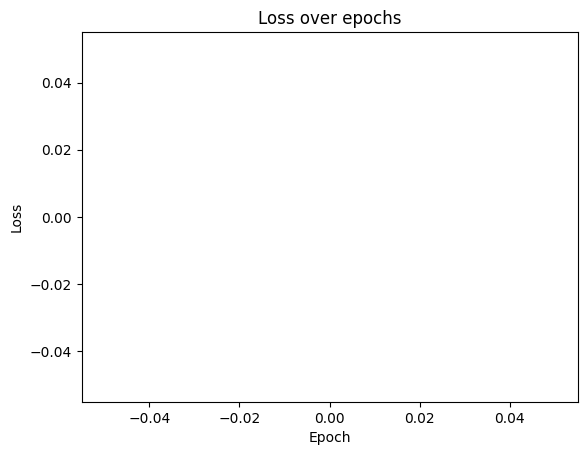

0


In [ ]:
def plot_loss(losses):
    plt.plot(losses[100:])
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
plot_loss(losses)
print(len(losses))

# Model Testing

In [ ]:
# test model
model.load_state_dict(torch.load('transformer_model.pth'))
model.eval()

with torch.no_grad():
    y_pred = model(X_test)
    loss = criterion(y_pred, y_test)
    print(f'Test Loss: {loss.item()}')
    y_test = y_test.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    # Plot the first 100 predictions
    plt.plot(y_test[:100, 0], label='True X')
    plt.plot(y_pred[:100, 0], label='Predicted X')
    plt.legend()
    plt.show()

    plt.plot(y_test[:100, 1], label='True Y')
    plt.plot(y_pred[:100, 1], label='Predicted Y')
    plt.legend()
    plt.show()

RuntimeError: Error(s) in loading state_dict for ECoGTransformerEncoder:
	Missing key(s) in state_dict: "pos_encoder.pos_embedding.weight". 

## Optuna, the hyperparameter optimizer

In [29]:

import optuna
import torch
import torch.nn as nn



# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    model_dim = trial.suggest_categorical('model_dim', [256, 512, 1024])
    num_heads = trial.suggest_categorical('num_heads', [8, 16, 32])
    num_layers = trial.suggest_int('num_layers',12,32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-4)
    
    # real data
    input_tensor = X_train
    target_tensor = y_train
    dataset = TensorDataset(input_tensor, target_tensor)
    generator = torch.Generator(device='cuda')
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, generator=generator)
    
    # Model and optimizer
    model = ECoGTransformerEncoder(input_dim=X_train.shape[-1], resolution, model_dim=model_dim, num_heads=num_heads, num_layers=num_layers, output_dim=2, dropout_rate=dropout_rate)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    # Training loop with mixed precision and gradient checkpointing
    scaler = GradScaler()
    scheduler = StepLR(optimizer, step_size=num_epochs//7, gamma=0.9)

    # Training loop
    print(trial.params)
    losses = []
    for epoch in range(100):
        for data, target in dataloader:
            optimizer.zero_grad()
            with autocast():
                output = model(data)
                loss = criterion(output, target)
                losses.append(loss.item())
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    # we want loss direction to be negative
    loss_grad = np.mean(losses[2:len(losses)//2]) // np.mean(losses[len(losses)//2:])
    return loss_grad

if run_optuna:
    # Run the optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Best hyperparameters
    print(study.best_params)

[I 2024-07-24 23:39:55,156] A new study created in memory with name: no-name-ba7af481-c749-49f2-82cb-30371f7786d9
C:\Users\thewa\AppData\Local\Temp\ipykernel_32612\2949406695.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\thewa\AppData\Local\Temp\ipykernel_32612\2949406695.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-4)
[W 2024-07-24 23:39:55,158] Trial 0 failed with parameters: {'model_dim': 512, 'num_heads': 8, 'num_layers': 31, 'dropout_rate': 0.44900400349482184, 'learning_rate': 0.00020727580704592698, 'weight

TypeError: ECoGTransformerEncoder.__init__() missing 1 required positional argument: 'resolution'

best trial with output dim 1:

[I 2024-07-22 11:58:14,634] Trial 15 finished with value: 753723.5625 and parameters: {'model_dim': 256, 'num_heads': 4, 'num_layers': 5, 'dropout_rate': 0.2259481444219587, 'learning_rate': 0.0009022268315380955}. Best is trial 15 with value: 753723.5625.

wrong output dim, trying 2.

best: {'model_dim': 512, 'num_heads': 8, 'num_layers': 6, 'dropout_rate': 0.48411131648232686, 'learning_rate': 0.0008203239127338236}

new optimization.

best: [I 2024-07-23 02:32:30,156] Trial 48 finished with value: 372409.4375 and parameters: {'model_dim': 128, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.3670812456459453, 'learning_rate': 0.0006976310761919828}. Best is trial 48 with value: 372409.4375.

new optimization + data formulation: 

[I 2024-07-23 14:57:13,025] Trial 41 finished with value: 0.005869156192056834 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.44199032873525623, 'learning_rate': 0.0006397189274255495, 'weight_decay': 4.145862002136959e-06}. Best is trial 41 with value: 0.005869156192056834.


half run, best: "{'model_dim': 512, 'num_heads': 8, 'num_layers': 9, 'dropout_rate': 0.14463139530411082, 'learning_rate': 0.0003710353587134264, 'weight_decay': 1.0055811166601365e-06}"
